In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
import gower
from sklearn.decomposition import PCA
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Data Loading

In [2]:
# Load the cleaned data
file_path = "../data/raw/cleaned.csv"
data = pd.read_csv(file_path)
data_original = data

In [3]:
# Load the raw data
file_path = "../data/raw/RTA_Dataset.csv"
data_uncleaned = pd.read_csv(file_path)

# Difference Analysis 

In [4]:
def get_columns_not_in_data(data, data_uncleaned):
    """
    Identifies columns that are present in the uncleaned dataset but not in the cleaned dataset.

    :param data: pd.DataFrame, cleaned DataFrame
    :param data_uncleaned: pd.DataFrame, uncleaned DataFrame
    :return: set, columns in data_uncleaned that are not in data
    """
    cleaned_columns = set(data.columns)
    uncleaned_columns = set(data_uncleaned.columns)

    columns_not_in_cleaned = uncleaned_columns - cleaned_columns
    return columns_not_in_cleaned

In [5]:
get_columns_not_in_data(data, data_uncleaned)

{'Age_band_of_casualty',
 'Area_accident_occured',
 'Casualty_class',
 'Casualty_severity',
 'Day_of_week',
 'Defect_of_vehicle',
 'Fitness_of_casuality',
 'Number_of_casualties',
 'Number_of_vehicles_involved',
 'Owner_of_vehicle',
 'Road_allignment',
 'Road_surface_conditions',
 'Service_year_of_vehicle',
 'Sex_of_casualty',
 'Time',
 'Type_of_vehicle',
 'Work_of_casuality'}

In [6]:
def test_datasets_equality(data_original, data_uncleaned, column_name):
    """
    Tests if a specific column in two datasets are equal.

    :param data_original: pd.Series, original dataset column
    :param data_uncleaned: pd.Series, uncleaned dataset column
    :param column_name: str, name of the column being compared
    :return: bool, True if all values in the columns are equal, False otherwise
    """
    return (data_original[column_name] == data_uncleaned[column_name]).all()

In [7]:
test_datasets_equality(data, data_uncleaned, "Age_band_of_driver")

True

# Feature Creation

In [8]:
def extract_time_of_day(data, time_column_name='Time'):
    """
    Extracts and categorizes time of day from a datetime column in a DataFrame.

    :param data: pd.DataFrame, DataFrame with uncleaned data
    :param time_column_name: str, name of the datetime column
    :return: pd.DataFrame, DataFrame with added 'Time_of_day' column
    """
    # Convert 'Time' column to datetime if not already
    data[time_column_name] = pd.to_datetime(data[time_column_name])
    
    # Extract hour from 'Time' column
    data['Hour'] = data[time_column_name].dt.hour
    
    # Define a function to categorize the hour into morning, afternoon, evening, or night
    def categorize_hour(hour):
        if 6 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 18:
            return 'Afternoon'
        elif 18 <= hour < 24:
            return 'Evening'
        else:
            return 'Night'
    
    # Apply the function to create a new column indicating the time of day
    data['Time_of_day'] = data['Hour'].apply(categorize_hour)
    
    # Drop the 'Hour' column if not needed anymore
    data.drop(columns=['Hour'], inplace=True)
    
    return data

In [9]:
data_uncleaned =extract_time_of_day(data_uncleaned)

C:\Users\Max_G\AppData\Local\Temp\ipykernel_26408\476543411.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[time_column_name] = pd.to_datetime(data[time_column_name])


# Exploratory Data Anaylsis and Data Preparation

In [10]:
data.head()

,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Lanes_or_Medians,Types_of_Junction,Road_surface_type,Light_conditions,Weather_conditions,Type_of_collision,Vehicle_movement,Pedestrian_movement,Cause_of_accident,Accident_severity
0,18-30,Male,Above high school,Employee,1-2yr,Unknown,No junction,Asphalt roads,Daylight,Normal,Collision with roadside-parked vehicles,Going straight,Not a Pedestrian,Moving Backward,2
1,31-50,Male,Junior high school,Employee,Above 10yr,Undivided Two way,No junction,Asphalt roads,Daylight,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2
2,18-30,Male,Junior high school,Employee,1-2yr,other,No junction,Asphalt roads,Daylight,Normal,Collision with roadside objects,Going straight,Not a Pedestrian,Changing lane to the left,1
3,18-30,Male,Junior high school,Employee,5-10yr,other,Y Shape,Earth roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Changing lane to the right,2
4,18-30,Male,Junior high school,Employee,2-5yr,other,Y Shape,Asphalt roads,Darkness - lights lit,Normal,Vehicle with vehicle collision,Going straight,Not a Pedestrian,Overtaking,2


## Cardinality Analysis

In [11]:
def analyze_columns(data):
    """
    Analyzes each column in a DataFrame to determine unique values and their counts.

    :param data: pd.DataFrame, DataFrame to analyze
    :return: dict, dictionary containing unique values and counts for each column
    """
    unique_values_dict = {}
    
    for column in data.columns:
        unique_values = data[column].unique()
        n_unique_values = data[column].nunique()
        unique_values_dict[column] = {
            "unique_values": unique_values,
            "n_unique_values": n_unique_values
        }
    
    return unique_values_dict

In [12]:
unique_values_dict= analyze_columns(data)

In [13]:
def print_unique_value_counts(unique_values_dict):
    """
    Prints the number of unique values for each column from a dictionary.

    :param unique_values_dict: dict, dictionary containing unique values and counts for each column
    """
    for column, info in unique_values_dict.items():
        n_unique_values = info["n_unique_values"]
        print(f"{column} has {n_unique_values} unique values")


In [14]:
print_unique_value_counts(unique_values_dict)

Age_band_of_driver has 5 unique values
Sex_of_driver has 3 unique values
Educational_level has 7 unique values
Vehicle_driver_relation has 4 unique values
Driving_experience has 8 unique values
Lanes_or_Medians has 7 unique values
Types_of_Junction has 8 unique values
Road_surface_type has 6 unique values
Light_conditions has 4 unique values
Weather_conditions has 9 unique values
Type_of_collision has 10 unique values
Vehicle_movement has 13 unique values
Pedestrian_movement has 9 unique values
Cause_of_accident has 20 unique values
Accident_severity has 3 unique values


## Missing Values Analysis and Imputing

In [15]:
data.replace("Unknown", pd.NA, inplace=True)

In [16]:
def plot_missing_values_heatmap(data):
    """
    Plots a heatmap showing the presence of missing values in a DataFrame.

    :param data: pd.DataFrame, input DataFrame
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.isna(), cmap='Greys_r', cbar=False)
    plt.title('Heatmap of Missing Values in Data')
    plt.show()


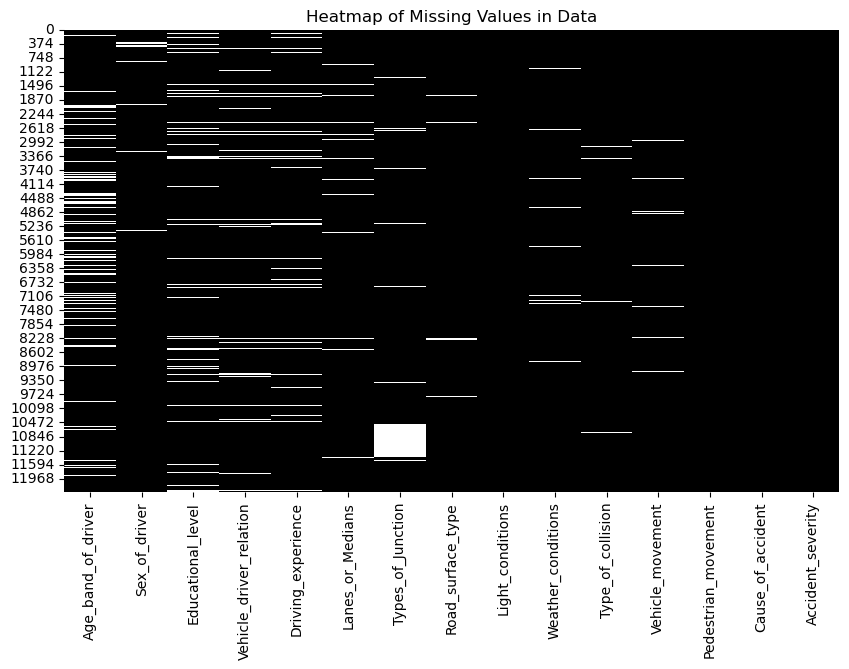

In [17]:
plot_missing_values_heatmap(data)

In [18]:
def apply_categorical_mappings(data):
    """
    Applies predefined mappings to specific categorical columns in a DataFrame.

    :param data: pd.DataFrame, input DataFrame
    :return: pd.DataFrame, DataFrame with mapped categorical columns
    """
    # Define mapping dictionaries
    age_band_mapping = {
        'Under 18': 0,
        '18-30': 1,
        '31-50': 2,
        'Over 51': 3
    }
    
    education_level_mapping = {
        'Illiterate': 0,
        'Writing & reading': 1,
        'Elementary school': 2,
        'Junior high school': 3,
        'High school': 4,
        'Above high school': 5
    }
    
    # Map categorical columns
    if 'Age_band_of_driver' in data.columns:
        data['Age_band_of_driver'] = data['Age_band_of_driver'].map(age_band_mapping)
    if 'Educational_level' in data.columns:
        data['Educational_level'] = data['Educational_level'].map(education_level_mapping)
    
    return data

In [19]:
data = apply_categorical_mappings(data)

In [20]:
def numerical_imputer(data):
    """
    Imputes missing values in numerical columns using iterative imputation.

    :param data: pd.DataFrame, input DataFrame
    :return: pd.DataFrame, DataFrame with imputed numerical columns
    """
    numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
    
    # Impute numerical variables
    imputer = IterativeImputer()
    data_imputed = data.copy()
    data_imputed[numerical_cols] = imputer.fit_transform(data_imputed[numerical_cols]).round(0)
    
    return data_imputed

def categorical_imputer(data):
    """
    Imputes missing values in categorical columns using the mode.

    :param data: pd.DataFrame, input DataFrame
    :return: pd.DataFrame, DataFrame with imputed categorical columns
    """
    categorical_cols = data.select_dtypes(include=['object']).columns
    
    # Quick imputing of categorical features
    data_imputed = data.copy()
    for col in categorical_cols:
        mode_val = data_imputed[col].mode()[0]  # Get the mode value of the column
        data_imputed[col].fillna(mode_val, inplace=True)
    
    return data_imputed

In [21]:
data_imputed = numerical_imputer(data)
data_imputed = categorical_imputer(data_imputed)

In [22]:
data['Time_of_day'] = data_uncleaned.Time_of_day

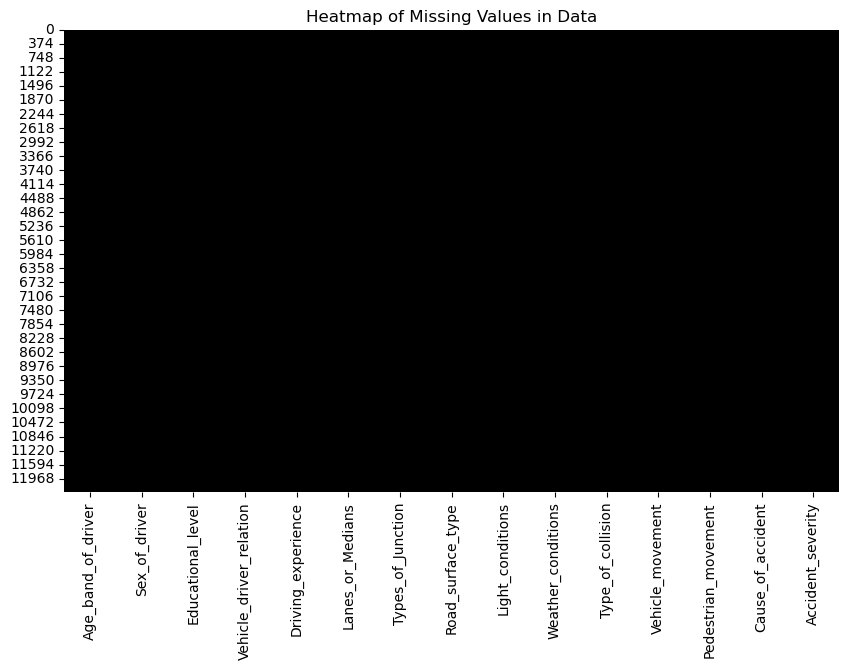

In [23]:
plot_missing_values_heatmap(data_imputed)

# Saving

In [24]:
data.to_csv("../data/interim/ordinal.csv", index=False)
data_imputed.to_csv("../data/interim/ordinal_and_imputed.csv", index=False)
data_no_nan = data.dropna()
data_no_nan.reset_index().drop(columns="index", inplace=True)
data_no_nan.to_csv("../data/interim/no_nan.csv", index=False)

# One Hot Encoding and PCA

In [25]:
data_one_hot_encoded = pd.get_dummies(data_no_nan).astype(int)
# Print the first few rows of the one-hot encoded DataFrame
data_one_hot_encoded.to_csv("../data/interim/ohe_no_nan.csv", index=False)

In [26]:
def find_optimal_pca_components(data, min_variance_ratio=0.90):
    """
    Finds the number of principal components that explain at least a specified variance ratio.

    :param data: pd.DataFrame, input DataFrame
    :param min_variance_ratio: float, minimum cumulative variance ratio to explain (default: 0.90)
    :return: tuple, (PCA object, int, float), PCA object with optimal components, 
             number of components, cumulative variance ratio
    """
    for comp in range(3, data.shape[1]):
        pca = PCA(n_components=comp, random_state=42)
        pca.fit(data)
        variance_ratio = pca.explained_variance_ratio_
        
        if np.cumsum(variance_ratio)[-1] >= min_variance_ratio:
            return pca, comp, np.cumsum(variance_ratio)[-1]
    
    # If no suitable number of components is found, return the last computed PCA
    return pca, comp, np.cumsum(variance_ratio)[-1]

In [27]:
def perform_pca(data, n_components):
    """
    Performs PCA transformation on the input data using the specified number of components.

    :param data: pd.DataFrame, input DataFrame
    :param n_components: int, number of principal components
    :return: np.ndarray, transformed data
    """
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(data)
    transformed_data = pca.transform(data)
    return transformed_data

In [28]:
pca, num_components, explained_variance_ratio = find_optimal_pca_components(data_one_hot_encoded)
print(f"Using {num_components} components, we can explain {explained_variance_ratio:.2%} of the variability in the original data.")

Using 32 components, we can explain 90.21% of the variability in the original data.


In [29]:
# Perform PCA transformation with optimal components
pca_data = perform_pca(data_one_hot_encoded, num_components)

In [30]:
file_path = '../data/interim/pca_non_nan.csv'
# Save the array as a CSV file
np.savetxt(file_path, pca_data, delimiter=",")

# Creation of Gower Distance

In [31]:
cat_list = list(data_imputed.columns)
true_list = [True] * len(cat_list)

## Gower Imputed

In [32]:
gower_matrix = gower.gower_matrix(data_imputed, cat_features=true_list)

In [33]:
df_gower_df = pd.DataFrame(gower_matrix)
# Save the DataFrame to a CSV file
csv_filepath_gower = '../data/interim/gower_imputed.csv'
df_gower_df.to_csv(csv_filepath_gower, index=False)

## Gower Droped NaN

In [34]:
cat_list = list(data_no_nan.columns)
true_list = [True] * len(cat_list)

In [35]:
gower_matrix_no_nan = gower.gower_matrix(data_no_nan, cat_features=true_list)

In [36]:
df_gower_df_no_nan = pd.DataFrame(gower_matrix_no_nan)
# Save the DataFrame to a CSV file
csv_filepath_gower_no_nan = '../data/interim/gower_no_nan.csv'
df_gower_df_no_nan.to_csv(csv_filepath_gower_no_nan, index=False)

# Oversampling 

In [37]:
data = pd.read_csv("../data/interim/ohe_no_nan.csv")

In [38]:
severity_0 = data.query("Accident_severity == 0")

# Calculate the desired number of samples to be 10% of the entire dataset
desired_count = int(0.10 * len(data))

# Oversample the severity_0 data
severity_0_oversampled = resample(severity_0, 
                                  replace=True,  # sample with replacement
                                  n_samples=desired_count,  # desired number of samples
                                  random_state=42)  # reproducible results

# Filter the data where Accident_severity is not 0
data_not_severity_0 = data.query("Accident_severity != 0")

# Combine the oversampled data with the rest of the data
data_oversampled = pd.concat([data_not_severity_0, severity_0_oversampled])

In [39]:
def oversample_and_combine(data, condition, oversample_percentage=0.10, random_state=42):
    """
    Performs oversampling on a specific class defined by a condition and combines it with the original data.

    :param data: pd.DataFrame, input DataFrame
    :param condition: str, condition to filter the class for oversampling
    :param oversample_percentage: float, desired percentage of oversampled data relative to the entire dataset (default: 0.10)
    :param random_state: int, random state for reproducible results (default: 42)
    :return: pd.DataFrame, combined data with oversampling
    """
    # Filter the data based on the condition
    class_data = data.query(condition)
    
    # Calculate the desired number of samples
    desired_count = int(oversample_percentage * len(data))
    
    # Perform oversampling
    oversampled_data = resample(class_data,
                                replace=True,     # sample with replacement
                                n_samples=desired_count,
                                random_state=random_state)
    
    # Filter out the original data where the condition does not apply
    data_not_class = data.query(f"not ({condition})")
    
    # Combine oversampled class with the rest of the data
    data_oversampled = pd.concat([data_not_class, oversampled_data])
    
    return data_oversampled

In [40]:
# Condition for oversampling
condition = "Accident_severity == 0"
# Oversample and combine data
data_oversampled = oversample_and_combine(data, condition)

In [41]:
def split_data(data, target_variable='Accident_severity', test_size=0.2, random_state=42):
    """
    Split oversampled data into training and testing sets.

    :param data_oversampled: pd.DataFrame, oversampled DataFrame
    :param target_variable: str, name of the target variable column (default: 'Accident_severity')
    :param test_size: float, proportion of the dataset to include in the test split (default: 0.2)
    :param random_state: int, random state for reproducible results (default: 42)
    :return: tuple, (X_train, X_test, y_train, y_test), training and testing sets for features and target variable
    """
    # Define features (X) and target variable (y) for oversampled data
    X = data.drop(target_variable, axis=1)
    y = data[target_variable]

    # Split the oversampled data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [42]:
X_train,_, y_train, _ = split_data(data_oversampled)
_, X_test, _, y_test = split_data(data)

In [43]:
train_oversampled = pd.concat([X_train, y_train], axis=1)
test_belonging_to_oversampled = pd.concat([X_test, y_test], axis=1)

In [44]:
file_path = '../data/interim/oversampled_train.csv'
train_oversampled.to_csv(file_path, index=False)
file_path = '../data/interim/oversampled_test.csv'
test_belonging_to_oversampled.to_csv(file_path, index=False)